<a href="https://colab.research.google.com/github/Juneyy/CSCI-566-Final-Project/blob/main/CSCI_566_final_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To get a better GPU, factory runtime reset until a GPU with 15 gb

In [ ]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv


name, driver_version, memory.total [MiB]
Tesla K80, 460.32.03, 11441 MiB


Connect to google drive 

In [ ]:
try:
    # --- Mount gdrive to /content/drive/My Drive/
    from google.colab import drive
    drive.mount('/content/drive')
    
except: pass

#Access to My Drive 
MOUNT_ROOT = '/content/drive/My Drive'

Mounted at /content/drive


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import random


SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

To fix the error for loading pretrained Resnet50

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

The difference type of noise:

0: noise free,
1: symmetric single,
2: symmetric all,
3: asymmetric single,
4: asymmetric all,

In [ ]:
class add_label_noise(object):
  def __init__(self, noise_type, alpha):
    self.noise_type = noise_type
    self.alpha = alpha
    #self.max_label = max_label
    #self.label_space = list(range(0, max_label+1)
  def __call__(self, tensor):
    label_space = list(range(min(tensor), max(tensor)+1))
    max_label = int(max(tensor))
    if self.noise_type == 1:     # symmetric_single: α% of label 0 -> j != i
        pivot = random.choice(label_space)
        candidates = list(set([x for x in label_space]) - set([pivot]))
        for i in range(len(tensor)):
            if tensor[i] == pivot and random.random() < self.alpha:
                tensor[i] = random.choice(candidates)
    elif self.noise_type == 2:   # symmetric_all: α% of label i -> j != i
        for i in range(len(tensor)):
            if random.random() < self.alpha:
                candidates = list(set([x for x in label_space]) - set([int(tensor[i])]))
                tensor[i] = random.choice(candidates)
    elif self.noise_type == 3:   # asymmetric_single: α% of label 0 -> 4
        pivot = random.choice(label_space)
        candidates = list(set([x for x in label_space]) - set([pivot]))
        noise_label = random.choice(candidates)
        for i in range(len(tensor)):
            if tensor[i] == pivot and random.random() < self.alpha:
                tensor[i] = noise_label
    elif self.noise_type == 4:   # asymmetric_all: α% of label i -> j = i + 1
        for i in range(len(tensor)):
            if random.random() < self.alpha:
                if int(tensor[i]) != max_label:
                    tensor[i] = tensor[i] + 1
                else:
                    tensor[i] = 0
    elif self.noise_type == 5:   # semantic
        pass
    return tensor    

Set the dataset and the amount of noise

In [ ]:
dataset = "MNIST" #CIFAR10, CIFAR100, MNIST
alpha = 0.40
noise_type = 2
best_model = '{}/{}_resnet50_{}_noisetype{}.pt'.format(MOUNT_ROOT, dataset, int(alpha*100), noise_type)
transform_train_label = add_label_noise(noise_type, alpha)

In [ ]:
transform_train_data = transforms.Compose([
    #torchvision.transforms.Resize(size = (224, 224)),  #CIFAR         
    torchvision.transforms.Resize(size = (32, 32)), #MNIST
    torchvision.transforms.Grayscale(3),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), #cifar-10
    #torchvision.transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)), #cifar-100
    torchvision.transforms.Normalize((0.1307,), (0.3081,)) #MNIST
                                          
])

    #torchvision.transforms.RandomCrop(32, padding=4),
    #torchvision.transforms.RandomHorizontalFlip(),                                            

transform_test = transforms.Compose([
    #torchvision.transforms.Resize(size = (224, 224)),  #CIFAR         
    torchvision.transforms.Resize(size = (32, 32)), #MNIST
    torchvision.transforms.Grayscale(3),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), #cifar-10
    #torchvision.transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)), #cifar-100
    torchvision.transforms.Normalize((0.1307,), (0.3081,)) #MNIST
])

torchvision.datasets.MNIST For MNIST
torchvision.datasets.CIFAR10 For CIFAR10
torchvision.datasets.CIFAR100 for CIFAR100

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform_train_data)


validset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform_test)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform_test)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
batch_size = 64


train_iterator = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


valid_iterator = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


test_iterator = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Let's display some of the training samples.
sample_images = []
dataset_it = iter(trainset)  # create simple iterator, later we will use proper DataLoader
for _ in range(5):
  sample = next(dataset_it)     # samples a tuple (image, label)
  sample_images.append(sample[0][0].data.cpu().numpy())

fig = plt.figure(figsize = (10, 50))   
ax1 = plt.subplot(111)
ax1.imshow(np.concatenate(sample_images, axis=1), cmap='gray')
plt.show()


NameError: ignored

Create the model and put it to CUDA

In [ ]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features

if dataset == "CIFAR100":
  model.fc = nn.Sequential(nn.Linear(num_ftrs, 100))
else:
  model.fc = nn.Sequential(nn.Linear(num_ftrs, 10))  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Set the hyperparameters 

In [ ]:
learning_rate = 1e-3
momentum = 0.9
weight_decay = 5e-4
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()   # create loss layer instance

In [ ]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # TODO: compute the accuracy

    temp = torch.argmax(preds.detach().clone(), dim = 1)
    #print(temp)
    acc = torch.eq(temp, y)
    acc[acc == True] = 1
    acc[acc == False] = 0
    acc = acc.sum()/acc.numel()
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for i, data in enumerate(iterator):
        
        inputs, labels = data[0], data[1]
        inputs = inputs.cuda()
        labels = transform_train_label(labels)
        labels = labels.cuda()
        optimizer.zero_grad()
        # forward
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        
        acc = accuracy(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for i, data in enumerate(iterator):
          inputs, labels = data[0], data[1].cuda()
          inputs = inputs.cuda() 
          outputs = model(inputs)

          loss = criterion(outputs, labels)
        
          acc = accuracy(outputs, labels)

          epoch_loss += loss.item()
          epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
best_valid_loss = float('inf')
epochs = 10
for epoch in range(epochs):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, opt, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
#    if valid_loss < best_valid_loss:
#        best_valid_loss = valid_loss
    torch.save(model.state_dict(), best_model)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [ ]:
#model.load_state_dict(torch.load(best_model))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

RuntimeError: ignored

In [ ]:
#Create a softmax instance 
softmax = nn.Softmax(dim = 1)

def img_cls_test_sr(dataloader, model, loss_func, thresholds, device):
    model.eval()
    risk, coverage = [], []
    for t in thresholds:
        start = time.time()
        curr_accu = 0
        curr_risk = 0
        curr_coverage = 0
        if t < 1.0:
            for i, (X, y) in enumerate(dataloader):
                X, y = X.to(device), y.to(device)
                pred = model(X)
                softmax_pred = softmax(pred)
                cover_mask = torch.max(softmax_pred, dim=1)[0] > t
                covered_pred = softmax_pred[cover_mask]
                covered_y = y[cover_mask]

                curr_coverage += covered_y.shape[0]
                curr_accu += (covered_pred.argmax(1) == covered_y).type(torch.float).sum().item()

            if curr_coverage != 0:
                curr_risk = 1 - curr_accu / curr_coverage
                curr_coverage /= len(dataloader.dataset)

        risk.append(curr_risk)
        coverage.append(curr_coverage)

        #print(f"threshold = {t:>0.12f} risk: {curr_risk:>0.8f} coverage: {curr_coverage:>0.4f} time: {(time.time()-start):>0.1f}")

        if curr_risk == 0 or curr_coverage == 0:
            break

    return risk, coverage

def thresholds_generator(decimal_place=1, step=0.1):
    thresholds = [0]
    curr = 0
    num_step = int(0.9 / step)
    for i in range(decimal_place):
        for j in range(num_step):
            curr += step
            thresholds.append(curr)
        step /= 10
    thresholds.append(1.0)

    return thresholds

def risk_coverage_plotter(filename, index, risk, coverage):
    print('Coverage:', coverage)
    print('Risk:', risk)
    plt.xlabel('Coverage')
    plt.ylabel('Risk')
    plt.plot(coverage, risk, label = "alpha = {}%".format(index))
    plt.legend()
    plt.plot()
    plt.savefig(filename)

In [ ]:
thresholds = thresholds_generator(decimal_place = 10, step = 0.025)
test_result = '{}/CSCI566 Graph/{}_test_result.txt'.format(MOUNT_ROOT, dataset)
risk_coverage = '{}/CSCI566 Graph/{}_risk_coverage.txt'.format(MOUNT_ROOT, dataset)

number_list = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80]

with open(test_result, 'w') as writefile1:
  with open(risk_coverage, 'w') as writefile2:
    for i in range(2, 5, 2):
      #for j in range(0, 51, 5):
      for j in number_list:
        print("{} {}".format(i,j))
        name_label = '{}/CSCI566 Graph/{}_resnet50_{}_noisetype{}.jpg'.format(MOUNT_ROOT, dataset, j, i)
        result_model = 0
        if j == 0:
          result_model = '{}/models/csci566/{}_resnet50.pt'.format(MOUNT_ROOT, dataset)
        else:
          result_model = '{}/models/csci566/{}_resnet50_{}_noisetype{}.pt'.format(MOUNT_ROOT,dataset, j, i)

        model.load_state_dict(torch.load(result_model))
        test_loss, test_acc = evaluate(model, test_iterator, criterion)
        writefile1.write("resnet50_{}_noisetype{}: Test Loss: {} | Test Acc: {}% \n".format(j, i, test_loss, test_acc*100))

        risk = 0
        coverage = 0

        risk, coverage = img_cls_test_sr(test_iterator, model, criterion, thresholds, device)
        
        writefile2.write("resnet50_{}_noisetype{}: \n".format(j, i, test_loss, test_acc*100))
        writefile2.write("risk = {}\n".format(risk))
        writefile2.write("coverage = {}\n".format(coverage))
        writefile2.write("\n")  


        risk_coverage_plotter(name_label, j,  risk, coverage)
      writefile2.write("\n")    
      plt.close()  

2 0
Coverage: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998, 0.9995, 0.9991, 0.9989, 0.9984, 0.998, 0.9973, 0.9969, 0.9963, 0.9956, 0.9953, 0.995, 0.9945, 0.994, 0.9935, 0.9928, 0.9918, 0.9901, 0.99, 0.9898, 0.9897, 0.9897, 0.9897, 0.9895, 0.9893, 0.989, 0.9889, 0.9887, 0.9886, 0.9886, 0.9885, 0.9885, 0.9885, 0.9881, 0.9875, 0.9874, 0.9872, 0.9869, 0.9868, 0.9865, 0.9863, 0.9861, 0.9859, 0.9856, 0.9851, 0.9847, 0.9837, 0.9826, 0.9819, 0.9813, 0.9803, 0.979, 0.9768, 0.9747, 0.9747, 0.9746, 0.9745, 0.9743, 0.9739, 0.9735, 0.9734, 0.973, 0.9727, 0.9723, 0.972, 0.9716, 0.9706, 0.9703, 0.9697, 0.9696, 0.9688, 0.968, 0.9674, 0.9669, 0.9656, 0.9646, 0.9635, 0.9624, 0.9612, 0.96, 0.9579, 0.9559, 0.9538, 0.9509, 0.9475, 0.9443, 0.9394, 0.9321, 0.925, 0.913, 0.9114, 0.9091, 0.9081, 0.9064, 0.9048, 0.9025, 0.9005, 0.8975, 0.8961, 0.8934, 0.8905, 0.8879, 0.8863, 0.8836, 0.8803, 0.8767, 0.8734, 0.869, 0.8623, 0.8581, 0.852, 0.8458, 0.8379, 0.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import matplotlib.pyplot as plt

In [ ]:
#CIFAR-10

def base():
    coverage = []
    risk = []
    return coverage, risk

''' ---------------------------------------------------------------------------------------------------- '''
# '''
#     RESNET50 CIFAR10
# '''
def resnet50_cifar10_type0():
    risk = [0.03480000000000005, 0.03480000000000005, 0.03480000000000005, 0.03480000000000005, 0.034334334334334304, 0.032707936189425135, 0.02875367014275587, 0.02452232553387146, 0.02075802953630068, 0.01607480563143515, 0.015601939700611411, 0.015326075467709588, 0.014847809948032697, 0.013955470331309283, 0.012307363013698613, 0.01161915008068859, 0.010962769998914546, 0.009346822080492645, 0.00799729668844329, 0.0076966610073571085, 0.007515372352539296, 0.007331042382588748, 0.006925207756232732, 0.006401303538175029, 0.00577353599622954, 0.004903133221717315, 0.004286589099816274, 0.003746770025839785, 0.0032590275061921137, 0.0030367045154475747, 0.0028123744475693213, 0.0028672856362643717, 0.0026525198938992522, 0.002443582003737288, 0.002261079288513712, 0.0014605647517039744, 0.0015091492171288579, 0.0013616028010114967, 0.001406752411575618, 0.0014604631754642217, 0.0013134851138353332, 0.001163331782224275, 0.001002506265664116, 0.0008349568605622304, 0.0009839291571006603, 0.00045620437956206406, 0.0004798464491362342, 0.0005122950819672623, 0.0005527915975677145, 0.000601322910402935, 0.0006688963210702559, 0.0007745933384972759, 0.0009372071227741197, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 0.999, 0.9967, 0.9877, 0.9787, 0.9683, 0.9518, 0.9486, 0.9461, 0.9429, 0.9387, 0.9344, 0.9295, 0.9213, 0.9094, 0.8878, 0.8835, 0.8782, 0.873, 0.8664, 0.8592, 0.8487, 0.8362, 0.8165, 0.774, 0.7671, 0.7574, 0.7467, 0.7324, 0.7163, 0.6957, 0.6634, 0.6162, 0.5301, 0.5141, 0.4976, 0.4793, 0.4568, 0.4298, 0.399, 0.3593, 0.3049, 0.2192, 0.2084, 0.1952, 0.1809, 0.1663, 0.1495, 0.1291, 0.1067, 0.0821]
    return coverage, risk

'''
    TYPE2 NOISE
'''
def resnet50_cifar10_type2_0dot05():
    risk = [0.03710000000000002, 0.03710000000000002, 0.03710000000000002, 0.03615061085519733, 0.03430583501006035, 0.028568513416998287, 0.02253842958039054, 0.016259298618490958, 0.010782264275497888, 0.005877311130157992, 0.0051774213915898315, 0.004861384837734906, 0.004722222222222183, 0.004058929645219478, 0.003568394222599802, 0.0035343035343035067, 0.004005722460658112, 0.003555104113763363, 0.0034305317324184736, 0.004192872117400381, 0.0026525198938992522, 0.0036101083032491488, 0.005319148936170248, 0.0]
    coverage = [1.0, 1.0, 1.0, 0.9986, 0.994, 0.9801, 0.9628, 0.941, 0.9089, 0.8167, 0.7919, 0.7611, 0.72, 0.6652, 0.5885, 0.481, 0.3495, 0.1969, 0.0583, 0.0477, 0.0377, 0.0277, 0.0188, 0.0122]
    return coverage, risk 

def resnet50_cifar10_type2_0dot10():
    risk = [0.03620000000000001, 0.03620000000000001, 0.03620000000000001, 0.03537074148296593, 0.031221582297665917, 0.025654234494127293, 0.01990940693142318, 0.013709063214013661, 0.008534019172316998, 0.0021036527060623866, 0.002027027027027062, 0.0019646365422396617, 0.0015319800842589215, 0.00170068027210879, 0.0019323671497584183, 0.0020790020790020236, 0.0]
    coverage = [1.0, 1.0, 1.0, 0.998, 0.9897, 0.9706, 0.9493, 0.9191, 0.8554, 0.5229, 0.444, 0.3563, 0.2611, 0.1764, 0.1035, 0.0481, 0.016]
    return coverage, risk

def resnet50_cifar10_type2_0dot15():
    risk = [0.04090000000000005, 0.04090000000000005, 0.04071221366409927, 0.03903271121814167, 0.03326889815851053, 0.024263251067374814, 0.01626886439045272, 0.010518070941031632, 0.00708860759493668, 0.00540784136998651, 0.006249999999999978, 0.00545454545454549, 0.0045045045045044585, 0.0053050397877983935, 0.010309278350515427, 0.02020202020202022, 0.0]
    coverage = [1.0, 1.0, 0.9997, 0.9966, 0.9829, 0.9603, 0.9343, 0.8937, 0.79, 0.2219, 0.16, 0.11, 0.0666, 0.0377, 0.0194, 0.0099, 0.0023]
    return coverage, risk

def resnet50_cifar10_type2_0dot20():
    risk = [0.03990000000000005, 0.03990000000000005, 0.03941970985492749, 0.03653381642512077, 0.028768108496866285, 0.018481147105682383, 0.012205947625388402, 0.007181773155027216, 0.00494951494753515, 0.002460024600245969, 0.0037105751391465214, 0.005970149253731294, 0.005714285714285672, 0.012195121951219523, 0.02777777777777779, 0.0]
    coverage = [1.0, 1.0, 0.9995, 0.9936, 0.9733, 0.9415, 0.9012, 0.8076, 0.5051, 0.0813, 0.0539, 0.0335, 0.0175, 0.0082, 0.0036, 0.0007]
    return coverage, risk

def resnet50_cifar10_type2_0dot25():
    risk = [0.04169999999999996, 0.04169999999999996, 0.04151245373612089, 0.03683891804602346, 0.026887280248190315, 0.01652446268495522, 0.010304503878661553, 0.007256235827664437, 0.006183017312448524, 0.0]
    coverage = [1.0, 1.0, 0.9997, 0.9908, 0.967, 0.9259, 0.8637, 0.6615, 0.2426, 0.0291]
    return coverage, risk

def resnet50_cifar10_type2_0dot30():
    risk = [0.043399999999999994, 0.043399999999999994, 0.043225935561336803, 0.037472149078387695, 0.025862068965517238, 0.016054030115146167, 0.011065006915629283, 0.005439161966156347, 0.003669724770642202, 0.0]
    coverage = [1.0, 1.0, 0.9994, 0.9874, 0.9512, 0.9032, 0.7953, 0.4964, 0.109, 0.002]
    return coverage, risk

##
def resnet50_cifar10_type2_0dot35():
    risk = [0.04420000000000002, 0.04420000000000002, 0.043569711538461564, 0.03584192790768914, 0.019961156668105273, 0.01019093358322598, 0.00614687803299907, 0.0035650623885917776, 0.0]
    coverage = [1.0, 1.0, 0.9984, 0.9793, 0.9268, 0.8537, 0.6182, 0.2244, 0.021]
    return coverage, risk

def resnet50_cifar10_type2_0dot40():
    risk = [0.04800000000000004, 0.04800000000000004, 0.04573721163490474, 0.03259519867549665, 0.01705358125206291, 0.009186840471756663, 0.005507307773776726, 0.005597014925373123, 0.0]
    coverage = [1.0, 1.0, 0.997, 0.9664, 0.9089, 0.8055, 0.4721, 0.1072, 0.0044]
    return coverage, risk

def resnet50_cifar10_type2_0dot45():
    risk = [0.05020000000000002, 0.05020000000000002, 0.04699134634735358, 0.02864721485411137, 0.013601348098218558, 0.005808621216753296, 0.004042631385520079, 0.002732240437158473, 0.0]
    coverage = [1.0, 1.0, 0.9938, 0.9425, 0.8308, 0.6542, 0.2721, 0.0366, 0.0006]
    return coverage, risk

def resnet50_cifar10_type2_0dot50():
    risk = [0.051899999999999946, 0.051899999999999946, 0.04682611767080436, 0.024747639205470517, 0.011828098304639267, 0.00512820512820511, 0.003089598352214229, 0.0]
    coverage = [1.0, 1.0, 0.9909, 0.9213, 0.7609, 0.4485, 0.0971, 0.0041]
    return coverage, risk                

'''
    TYPE4 NOISE
'''
def resnet50_cifar10_type4_0dot05():
    risk = [0.03979999999999995, 0.03979999999999995, 0.03979999999999995, 0.039231385108086436, 0.037828617298815925, 0.03363728470111449, 0.02651593011305242, 0.021548117154811752, 0.014688538651227656, 0.008515535097813554, 0.008119557542951239, 0.006436725771192586, 0.006019467213114749, 0.005527152134862545, 0.004912058310885703, 0.005017057997190433, 0.005071315372424667, 0.002483443708609312, 0.0]
    coverage = [1.0, 1.0, 1.0, 0.9992, 0.9966, 0.987, 0.973, 0.956, 0.9327, 0.869, 0.8498, 0.8234, 0.7808, 0.7237, 0.6311, 0.4983, 0.3155, 0.1208, 0.0106]
    return coverage, risk

def resnet50_cifar10_type4_0dot10():
    risk = [0.039000000000000035, 0.039000000000000035, 0.039000000000000035, 0.03880776155231047, 0.03645310303273752, 0.030706659888154575, 0.02334509234280968, 0.016564026332554715, 0.011101243339253997, 0.005164034021871156, 0.005457746478873204, 0.00520833333333337, 0.005281690140845119, 0.005178907721280601, 0.00867052023121384, 0.0055096418732781816, 0.0]
    coverage = [1.0, 1.0, 1.0, 0.9998, 0.9958, 0.9835, 0.9638, 0.9418, 0.9008, 0.6584, 0.568, 0.4608, 0.3408, 0.2124, 0.1038, 0.0363, 0.0086]
    return coverage, risk

def resnet50_cifar10_type4_0dot15():
    risk = [0.04049999999999998, 0.04049999999999998, 0.04049999999999998, 0.04012808966276393, 0.0381526104417671, 0.03402396912451755, 0.026719138359569183, 0.020342954521248235, 0.013587954461990459, 0.011426465167711064, 0.011015325670498122, 0.011280690112806857, 0.012513034410844615, 0.012499999999999956, 0.017751479289940808, 0.0]
    coverage = [1.0, 1.0, 1.0, 0.9993, 0.996, 0.9846, 0.9656, 0.9389, 0.8169, 0.2713, 0.2088, 0.1507, 0.0959, 0.048, 0.0169, 0.0037]
    return coverage, risk

def resnet50_cifar10_type4_0dot20():
    risk = [0.04059999999999997, 0.04059999999999997, 0.04059999999999997, 0.0400360324291863, 0.03671575549727657, 0.030126037503842573, 0.021354933726067782, 0.01464713715046606, 0.011530593267621403, 0.016925246826516194, 0.011437908496731986, 0.013207547169811318, 0.017114914425427896, 0.023809523809523836, 0.0092592592592593, 0.0]
    coverage = [1.0, 1.0, 1.0, 0.9991, 0.9914, 0.9759, 0.9506, 0.9012, 0.5377, 0.0709, 0.0612, 0.053, 0.0409, 0.0252, 0.0108, 0.0027] 
    return coverage, risk

def resnet50_cifar10_type4_0dot25():
    risk = [0.04700000000000004, 0.04700000000000004, 0.04700000000000004, 0.04645574689627552, 0.04099190283400811, 0.03319201737152311, 0.022500554200842404, 0.01634035036066539, 0.010715520221223684, 0.0]
    coverage = [1.0, 1.0, 1.0, 0.9988, 0.988, 0.9671, 0.9022, 0.6793, 0.2893, 0.0108]
    return coverage, risk

def resnet50_cifar10_type4_0dot30():
    risk = [0.04820000000000002, 0.04820000000000002, 0.04820000000000002, 0.04764764764764762, 0.042686627554116896, 0.03270205940184212, 0.021340446815605207, 0.014881970578173087, 0.012558869701726816, 0.0]
    coverage = [1.0, 1.0, 1.0, 0.999, 0.9886, 0.9663, 0.8997, 0.5846, 0.1274, 0.0004]
    return coverage, risk

##
def resnet50_cifar10_type4_0dot35():
    risk = [0.059699999999999975, 0.059699999999999975, 0.05970597059705973, 0.05824561403508777, 0.052332080073163256, 0.04211843202668886, 0.025525724110567416, 0.0190394998579142, 0.015100671140939603, 0.0]
    coverage = [1.0, 1.0, 0.9999, 0.9975, 0.9841, 0.9592, 0.7561, 0.3519, 0.0596, 0.0003]
    return coverage, risk

def resnet50_cifar10_type4_0dot40():
    risk = [0.14890000000000003, 0.14890000000000003, 0.1488148814881488, 0.1469850506672018, 0.14128776319804703, 0.1275585566575227, 0.03844652615144417, 0.030864197530864224, 0.04081632653061229, 0.0]
    coverage = [1.0, 1.0, 0.9999, 0.9967, 0.9831, 0.9478, 0.5124, 0.243, 0.0343, 0.0002]
    return coverage, risk

def resnet50_cifar10_type4_0dot45():
    risk = [0.28659999999999997, 0.28659999999999997, 0.28662866286628663, 0.2850828729281768, 0.28012263668880943, 0.26898093919710364, 0.07664537628436541, 0.06627393225331368, 0.13636363636363635, 0]
    coverage = [1.0, 1.0, 0.9999, 0.9955, 0.9785, 0.9391, 0.3601, 0.0679, 0.0044, 0]
    return coverage, risk

def resnet50_cifar10_type4_0dot50():
    risk = [0.5191, 0.5191, 0.5191519151915192, 0.518045641902081, 0.516403526758253, 0.5142027114267269, 0.3647798742138365, 0.1974683544303798, 0.34375, 0.0]
    coverage = [1.0, 1.0, 0.9999, 0.9947, 0.9754, 0.9294, 0.2862, 0.0395, 0.0032, 0.0003]
    return coverage, risk      

# '''
#     RESNET50 CIFAR10
# '''
CIFAR10_2 = []
CIFAR10_4 = []

coverageandrisk  = resnet50_cifar10_type0()
CIFAR10_2.append(coverageandrisk)
CIFAR10_4.append(coverageandrisk)


# '''
#     TYPE2 NOISE
# '''
CIFAR10_2.append(resnet50_cifar10_type2_0dot05())
CIFAR10_2.append(resnet50_cifar10_type2_0dot10())
CIFAR10_2.append(resnet50_cifar10_type2_0dot15())
CIFAR10_2.append(resnet50_cifar10_type2_0dot20())
CIFAR10_2.append(resnet50_cifar10_type2_0dot25())
CIFAR10_2.append(resnet50_cifar10_type2_0dot30())
CIFAR10_2.append(resnet50_cifar10_type2_0dot35())
CIFAR10_2.append(resnet50_cifar10_type2_0dot40())
CIFAR10_2.append(resnet50_cifar10_type2_0dot45())
CIFAR10_2.append(resnet50_cifar10_type2_0dot50())

print("Type 2")
CIFAR10_2_AURC = []
for item in CIFAR10_2:
  print(auc(item[0], item[1]))
  CIFAR10_2_AURC.append(auc(item[0], item[1]))

# print()
# plt.title('RESNET50 on CIFAR10: α% of label i -> j != i, type 2')
# plt.xlabel('Coverage')
# plt.ylabel('Risk')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 0.11])
# plt.plot(coverage0, risk0, label='alpha = 0.00 (no noise)')
# plt.plot(coverage1, risk1, label='alpha = 0.10')


# '''
#     TYPE2 NOISE
# '''

CIFAR10_4.append(resnet50_cifar10_type4_0dot05())
CIFAR10_4.append(resnet50_cifar10_type4_0dot10())
CIFAR10_4.append(resnet50_cifar10_type4_0dot15())
CIFAR10_4.append(resnet50_cifar10_type4_0dot20())
CIFAR10_4.append(resnet50_cifar10_type4_0dot25())
CIFAR10_4.append(resnet50_cifar10_type4_0dot30())
CIFAR10_4.append(resnet50_cifar10_type4_0dot35())
CIFAR10_4.append(resnet50_cifar10_type4_0dot40())
CIFAR10_4.append(resnet50_cifar10_type4_0dot45())
CIFAR10_4.append(resnet50_cifar10_type4_0dot50())

print("Type 4")
CIFAR10_4_AURC = []
for item in CIFAR10_4:
  print(auc(item[0], item[1]))
  CIFAR10_4_AURC.append(auc(item[0], item[1]))
# print()
# plt.title('RESNET50 on CIFAR10: α% of label i -> j != i, type 4')
# plt.xlabel('Coverage')
# plt.ylabel('Risk')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 0.11])
# plt.plot(coverage0, risk0, label='alpha = 0.00 (no noise)')
# plt.plot(coverage1, risk1, label='alpha = 0.10')



Type 2
0.0033974208384812713
0.005840781508405527
0.005279179109725561
0.008190291156614609
0.007080849856850709
0.008096258862206824
0.008552853736377784
0.007594112026483792
0.00888630867739479
0.009043908094547594
0.01010945371410526
Type 4
0.0033974208384812713
0.0063494629407039975
0.0077409258531923215
0.01385543278865915
0.014808596154477941
0.01420758643800617
0.01593516754590748
0.023377508336836727
0.06084480037593851
0.14458108620141635
0.3987906733782104


In [ ]:
#CIFAR-100

def base():
    coverage = []
    risk = []
    return coverage, risk

''' ---------------------------------------------------------------------------------------------------- '''
# '''
#     RESNET50 CIFAR100
# '''
def resnet50_cifar100_type0():
    risk = [0.17420000000000002, 0.17420000000000002, 0.1713511343103794, 0.1627315285975982, 0.15126924677486475, 0.13411078717201164, 0.11436683702441797, 0.09539789069990412, 0.0757633831608534, 0.053282182438192716, 0.050788597887425846, 0.047990578536728945, 0.04402043269230771, 0.040885336612357825, 0.03693136788714535, 0.03355815101167958, 0.029111072604401267, 0.02319539803303028, 0.016249732734659017, 0.015796401930671333, 0.014831460674157304, 0.0144018583042973, 0.013217976447969293, 0.011403953370501818, 0.010834236186348822, 0.009865470852017943, 0.007017543859649145, 0.0038058991436726863, 0.004012036108325012, 0.004266666666666641, 0.004013761467889898, 0.0031172069825435855, 0.0035112359550562022, 0.0024154589371980784, 0.0009881422924901129, 0.001322751322751281, 0.0024390243902439046, 0.0026385224274406704, 0.002941176470588225, 0.0032573289902280145, 0.0039525691699604515, 0.0046948356807511304, 0.0060606060606061, 0.008196721311475419, 0.0]
    coverage = [1.0, 1.0, 0.9962, 0.9826, 0.9612, 0.9261, 0.8805, 0.8344, 0.7827, 0.7038, 0.6911, 0.6793, 0.6656, 0.6506, 0.6309, 0.6079, 0.5771, 0.5389, 0.4677, 0.4558, 0.445, 0.4305, 0.4161, 0.3946, 0.3692, 0.3345, 0.285, 0.2102, 0.1994, 0.1875, 0.1744, 0.1604, 0.1424, 0.1242, 0.1012, 0.0756, 0.041, 0.0379, 0.034, 0.0307, 0.0253, 0.0213, 0.0165, 0.0122, 0.0076]
    return coverage, risk

'''
    TYPE2 NOISE
'''
def resnet50_cifar100_type2_0dot05():
    risk = [0.17500000000000004, 0.17450470282169306, 0.16366412213740456, 0.14841772151898736, 0.12952338923212714, 0.10880525266737018, 0.08565310492505351, 0.06761565836298933, 0.05116065974343309, 0.032376180381576414, 0.030399999999999983, 0.028207271207689066, 0.025319242624394556, 0.022636170714454118, 0.019703172978505656, 0.01909375890567111, 0.01749174917491747, 0.016631130063965882, 0.01133947554925585, 0.010794140323824197, 0.010970464135021119, 0.010526315789473717, 0.006688963210702337, 0.0054421768707483276, 0.005025125628140725, 0.0021413276231263545, 0.0034602076124568004, 0.0] 
    coverage = [1.0, 0.9994, 0.9825, 0.948, 0.9064, 0.8529, 0.7939, 0.7306, 0.6548, 0.5189, 0.5, 0.4786, 0.4542, 0.4241, 0.3908, 0.3509, 0.303, 0.2345, 0.1411, 0.1297, 0.1185, 0.1045, 0.0897, 0.0735, 0.0597, 0.0467, 0.0289, 0.0106]
    return coverage, risk 

def resnet50_cifar100_type2_0dot10():
    risk = [0.17659999999999998, 0.17461113898645253, 0.1585529715762274, 0.13797577854671284, 0.1168110918544194, 0.08989187830022627, 0.06731828193832601, 0.052639656230816456, 0.03511006003274508, 0.023532522474881024, 0.02167712492869367, 0.020332717190388205, 0.018398637137989726, 0.016751071289442976, 0.014123006833713037, 0.01231113598209288, 0.012869038607115857, 0.00824499411071844, 0.0026109660574412663, 0.003012048192771122, 0.0035460992907800915, 0.0] 
    coverage = [1.0, 0.9965, 0.9675, 0.9248, 0.8655, 0.7954, 0.7264, 0.6516, 0.5497, 0.3782, 0.3506, 0.3246, 0.2935, 0.2567, 0.2195, 0.1787, 0.1321, 0.0849, 0.0383, 0.0332, 0.0282, 0.0231] 
    return coverage, risk

def resnet50_cifar100_type2_0dot15():
    risk = [0.17689999999999995, 0.17385187418349912, 0.15312107247591122, 0.13144444444444447, 0.1051938726663475, 0.07814761215629518, 0.05635859249525477, 0.03746253746253747, 0.027505730360491754, 0.01999310582557734, 0.01867064973861088, 0.01903185767480342, 0.016075650118203333, 0.014991671293725695, 0.013651877133105783, 0.009649122807017574, 0.006053268765133124, 0.004319654427645814, 0.0] 
    coverage = [1.0, 0.9951, 0.9548, 0.9, 0.8356, 0.7601, 0.6849, 0.6006, 0.4799, 0.2901, 0.2678, 0.2417, 0.2115, 0.1801, 0.1465, 0.114, 0.0826, 0.0463, 0.0169] 
    return coverage, risk

def resnet50_cifar100_type2_0dot20():
    risk = [0.17989999999999995, 0.17393498889561887, 0.149749707104058, 0.12076124567474045, 0.09023894255210985, 0.06577828182591439, 0.04729729729729726, 0.033781190019193885, 0.019654088050314433, 0.008201202843083677, 0.00691823899371069, 0.005204460966542701, 0.0061619718309858795, 0.0021715526601520097, 0.0014164305949008194, 0.0] 
    coverage =  [1.0, 0.9906, 0.9389, 0.867, 0.7868, 0.7054, 0.6216, 0.521, 0.3816, 0.1829, 0.159, 0.1345, 0.1136, 0.0921, 0.0706, 0.0492] 
    return coverage, risk

def resnet50_cifar100_type2_0dot25():
    risk = [0.18589999999999995, 0.17842323651452285, 0.14501740644038297, 0.1136960152708184, 0.08576789064593948, 0.05969004143010592, 0.04203341117298365, 0.029633006610439883, 0.020194986072423426, 0.012280701754386003, 0.012307692307692353, 0.012195121951219523, 0.010703363914373099, 0.007692307692307665, 0.0079155672823219, 0.011111111111111072, 0.012345679012345734, 0.0] 
    coverage =  [1.0, 0.9881, 0.9192, 0.8382, 0.7462, 0.6517, 0.5567, 0.4387, 0.2872, 0.114, 0.0975, 0.082, 0.0654, 0.052, 0.0379, 0.027, 0.0162, 0.0079]
    return coverage, risk

def resnet50_cifar100_type2_0dot30():
    risk = [0.1854, 0.17636899319313215, 0.14059753954305798, 0.10822404706459121, 0.07857043526630514, 0.055881394591072, 0.03729418766117831, 0.02689164249934084, 0.019059720457433316, 0.013683010262257711, 0.010958904109588996, 0.011725293132328285, 0.010504201680672232, 0.011560693641618491, 0.008130081300813052, 0.0] 
    coverage =  [1.0, 0.9843, 0.9104, 0.8159, 0.7191, 0.6138, 0.5041, 0.3793, 0.2361, 0.0877, 0.073, 0.0597, 0.0476, 0.0346, 0.0246, 0.016] 
    return coverage, risk

##
def resnet50_cifar100_type2_0dot35():
    risk = [0.1846, 0.1709945601970646, 0.12676217765042985, 0.09239059009068207, 0.0632599661382176, 0.04348641049671975, 0.02989463366821854, 0.020014295925661174, 0.015613910574875822, 0.010840108401083959, 0.0066225165562914245, 0.0]
    coverage = [1.0, 0.9743, 0.8725, 0.7609, 0.6497, 0.5335, 0.4081, 0.2798, 0.1409, 0.0369, 0.0302, 0.0219]
    return coverage, risk

def resnet50_cifar100_type2_0dot40():
    risk = [0.18689999999999996, 0.16863354037267075, 0.12115135071369587, 0.08067881485603001, 0.05386298602928796, 0.03761822871883058, 0.022884673291177382, 0.013326499231163469, 0.012453300124533051, 0.012658227848101222, 0.016129032258064502, 0.021276595744680882, 0.016949152542372836, 0.023809523809523836, 0.040000000000000036, 0.11111111111111116, 0.16666666666666663, 0.0]
    coverage = [1.0, 0.966, 0.8477, 0.7189, 0.5941, 0.4652, 0.3321, 0.1951, 0.0803, 0.0158, 0.0124, 0.0094, 0.0059, 0.0042, 0.0025, 0.0009, 0.0006, 0.0003]
    return coverage, risk

def resnet50_cifar100_type2_0dot45():
    risk = [0.18710000000000004, 0.16074628438916416, 0.10941161958801038, 0.06650653055096833, 0.03880711145096538, 0.024158314058082775, 0.011498658489842883, 0.006254343293954134, 0.0018518518518518823, 0.0]
    coverage = [1.0, 0.9487, 0.8107, 0.6661, 0.5231, 0.3891, 0.2609, 0.1439, 0.054, 0.0088]
    return coverage, risk

def resnet50_cifar100_type2_0dot50():
    risk = [0.1894, 0.15713367609254503, 0.09588327253778006, 0.050489951835243296, 0.0279017857142857, 0.017253278122843385, 0.013245033112582738, 0.003984063745019917, 0.004347826086956497, 0.0]
    coverage = [1.0, 0.9336, 0.7676, 0.6021, 0.448, 0.2898, 0.1661, 0.0753, 0.023, 0.0033] 
    return coverage, risk  

'''
    TYPE4 NOISE
'''
def resnet50_cifar100_type4_0dot05():
    risk = [0.1814, 0.1810724289715886, 0.17636969024316418, 0.16184851310744996, 0.14466895958727433, 0.12147406733393995, 0.09886115822631447, 0.07806208598519293, 0.059151307329618485, 0.03893116262608387, 0.03741245853298936, 0.034436061133681584, 0.03318219291014013, 0.03156480859637345, 0.027476682631711657, 0.026058631921824116, 0.02104055087987755, 0.018957345971563955, 0.020472440944881876, 0.02226345083487946, 0.022222222222222254, 0.02631578947368418, 0.02316602316602312, 0.02717391304347827, 0.02631578947368418, 0.014705882352941124, 0.0] 
    coverage =  [1.0, 0.9996, 0.9911, 0.9651, 0.9304, 0.8792, 0.8254, 0.7699, 0.6999, 0.5651, 0.5426, 0.5169, 0.4852, 0.4467, 0.3967, 0.3377, 0.2614, 0.1688, 0.0635, 0.0539, 0.045, 0.0342, 0.0259, 0.0184, 0.0114, 0.0068, 0.0025] 
    return coverage, risk

def resnet50_cifar100_type4_0dot10():
    risk = [0.18820000000000003, 0.18795638691607486, 0.18051199028635034, 0.166008316008316, 0.14499837080482236, 0.12206085753803597, 0.09751268407375324, 0.07452409882543543, 0.05000774113639883, 0.02709832134292567, 0.025545502927088903, 0.023666866387058172, 0.02310924369747902, 0.01920614596670933, 0.018630136986301338, 0.019440124416796323, 0.016645326504481472, 0.015105740181268867, 0.0] 
    coverage =  [1.0, 0.9997, 0.9883, 0.962, 0.9207, 0.8676, 0.8081, 0.7407, 0.6459, 0.417, 0.3758, 0.3338, 0.2856, 0.2343, 0.1825, 0.1286, 0.0781, 0.0331, 0.007] 
    return coverage, risk

def resnet50_cifar100_type4_0dot15():
    risk = [0.18789999999999996, 0.1871684516064458, 0.1772653392929704, 0.16066365641079494, 0.13797300287674263, 0.1127578847521935, 0.08917279648986964, 0.06724037339556588, 0.04742933029785623, 0.03160667251975413, 0.03083466241360977, 0.02828947368421053, 0.027312775330396444, 0.03037974683544309, 0.031936127744510934, 0.03050847457627115, 0.039735099337748325, 0.021739130434782594, 0.0] 
    coverage =  [1.0, 0.9991, 0.9844, 0.9523, 0.9038, 0.8434, 0.7749, 0.6856, 0.5271, 0.2278, 0.1881, 0.152, 0.1135, 0.079, 0.0501, 0.0295, 0.0151, 0.0046, 0.0007] 
    return coverage, risk

def resnet50_cifar100_type4_0dot20():
    risk = [0.19610000000000005, 0.19569784892446218, 0.18522287807856708, 0.1659786175505451, 0.13882643884892087, 0.10821350231537896, 0.08236738033546975, 0.06089532587228441, 0.03975935129479469, 0.022805017103762815, 0.020155038759689936, 0.015837104072398245, 0.01098901098901095, 0.011363636363636354, 0.01041666666666663, 0.025000000000000022, 0.0625, 0.25, 0] 
    coverage =  [1.0, 0.9995, 0.9826, 0.9447, 0.8896, 0.8206, 0.7333, 0.6076, 0.3823, 0.0877, 0.0645, 0.0442, 0.0273, 0.0176, 0.0096, 0.004, 0.0016, 0.0004, 0] 
    return coverage, risk

def resnet50_cifar100_type4_0dot25():
    risk = [0.20730000000000004, 0.20662729001902091, 0.19553015613838143, 0.17406107032663054, 0.14532832593604184, 0.11115264797507785, 0.08020378457059685, 0.058892355694227794, 0.04543704274162497, 0.03736263736263734, 0.03988603988603989, 0.028340080971659964, 0.018404907975460127, 0.010752688172043001, 0.0] 
    coverage =  [1.0, 0.9989, 0.9799, 0.9399, 0.8787, 0.8025, 0.687, 0.5128, 0.2597, 0.0455, 0.0351, 0.0247, 0.0163, 0.0093, 0.0045] 
    return coverage, risk

def resnet50_cifar100_type4_0dot30():
    risk = [0.24029999999999996, 0.23928285256410253, 0.22657128257537051, 0.20182599355531683, 0.17030669144981414, 0.13062182244818143, 0.07675326880624889, 0.05327203893996757, 0.03681885125184092, 0.036363636363636376, 0.026666666666666616, 0.021276595744680882, 0.03703703703703709, 0.05555555555555558, 0.0] 
    coverage =  [1.0, 0.9984, 0.9785, 0.931, 0.8608, 0.7671, 0.5889, 0.3698, 0.1358, 0.011, 0.0075, 0.0047, 0.0027, 0.0018, 0.0009] 
    return coverage, risk

##
def resnet50_cifar100_type4_0dot35():
    risk = [0.27090000000000003, 0.2693926638604931, 0.2569344565440723, 0.23374512353706112, 0.19997630612486672, 0.1601620526671168, 0.09692578813393382, 0.059020044543429795, 0.06215469613259672, 0.10344827586206895, 0.10526315789473684, 0.2222222222222222, 0.0]
    coverage = [1.0, 0.9978, 0.9734, 0.9228, 0.8441, 0.7405, 0.5107, 0.2694, 0.0724, 0.0029, 0.0019, 0.0009, 0.0004] 
    return coverage, risk

def resnet50_cifar100_type4_0dot40():
    risk = [0.3578, 0.35690674146048285, 0.3427215516352007, 0.31844553913519436, 0.2910876856732152, 0.2500701655907943, 0.14956521739130435, 0.09181761399125543, 0.09169054441260749, 0.11111111111111116, 0.09090909090909094, 0.125, 0.0]
    coverage = [1.0, 0.9983, 0.9693, 0.9135, 0.8348, 0.7126, 0.4025, 0.1601, 0.0349, 0.0018, 0.0011, 0.0008, 0.0005]
    return coverage, risk

def resnet50_cifar100_type4_0dot45():
    risk = [0.43989999999999996, 0.43907815631262526, 0.4276897757663032, 0.4048321854159834, 0.37855421686746993, 0.3406971740065987, 0.27114716106604864, 0.2035555555555556, 0.1842105263157895, 0.3846153846153846, 0.4, 0.2857142857142857, 0.33333333333333337, 0.19999999999999996, 0.33333333333333337, 0.0]
    coverage = [1.0, 0.998, 0.9722, 0.9147, 0.83, 0.6971, 0.3452, 0.1125, 0.019, 0.0013, 0.001, 0.0007, 0.0006, 0.0005, 0.0003, 0.0001]
    return coverage, risk

def resnet50_cifar100_type4_0dot50():
    risk = [0.6042000000000001, 0.603448275862069, 0.5961439323641613, 0.5810421286031042, 0.5642857142857143, 0.5481171548117154, 0.5725938009787928, 0.6277145811789038, 0.7, 0.8571428571428572, 1.0, 1.0, 1.0, 0]
    coverage = [1.0, 0.9976, 0.9699, 0.902, 0.812, 0.6692, 0.3065, 0.0967, 0.016, 0.0007, 0.0005, 0.0004, 0.0003, 0]
    return coverage, risk      

# '''
#     RESNET50 CIFAR100
# '''

CIFAR100_2 = []
CIFAR100_4 = []

coverageandrisk  = resnet50_cifar100_type0()
CIFAR100_2.append(coverageandrisk)
CIFAR100_4.append(coverageandrisk)


# '''
#     TYPE2 NOISE
# '''
CIFAR100_2.append(resnet50_cifar100_type2_0dot05())
CIFAR100_2.append(resnet50_cifar100_type2_0dot10())
CIFAR100_2.append(resnet50_cifar100_type2_0dot15())
CIFAR100_2.append(resnet50_cifar100_type2_0dot20())
CIFAR100_2.append(resnet50_cifar100_type2_0dot25())
CIFAR100_2.append(resnet50_cifar100_type2_0dot30())
CIFAR100_2.append(resnet50_cifar100_type2_0dot35())
CIFAR100_2.append(resnet50_cifar100_type2_0dot40())
CIFAR100_2.append(resnet50_cifar100_type2_0dot45())
CIFAR100_2.append(resnet50_cifar100_type2_0dot50())

print("Type 2")
CIFAR100_2_AURC = []
for item in CIFAR100_2:
  print(auc(item[0], item[1]))
  CIFAR100_2_AURC.append(auc(item[0], item[1]))

# print()
# plt.title('RESNET50 on CIFAR10: α% of label i -> j != i, type 2')
# plt.xlabel('Coverage')
# plt.ylabel('Risk')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 0.11])
# plt.plot(coverage0, risk0, label='alpha = 0.00 (no noise)')
# plt.plot(coverage1, risk1, label='alpha = 0.10')


# '''
#     TYPE2 NOISE
# '''

CIFAR100_4.append(resnet50_cifar100_type4_0dot05())
CIFAR100_4.append(resnet50_cifar100_type4_0dot10())
CIFAR100_4.append(resnet50_cifar100_type4_0dot15())
CIFAR100_4.append(resnet50_cifar100_type4_0dot20())
CIFAR100_4.append(resnet50_cifar100_type4_0dot25())
CIFAR100_4.append(resnet50_cifar100_type4_0dot30())
CIFAR100_4.append(resnet50_cifar100_type4_0dot35())
CIFAR100_4.append(resnet50_cifar100_type4_0dot40())
CIFAR100_4.append(resnet50_cifar100_type4_0dot45())
CIFAR100_4.append(resnet50_cifar100_type4_0dot50())

print("Type 4")
CIFAR100_4_AURC = []
for item in CIFAR100_4:
  print(auc(item[0], item[1]))
  CIFAR100_4_AURC.append(auc(item[0], item[1]))
# print()
# plt.title('RESNET50 on CIFAR10: α% of label i -> j != i, type 4')
# plt.xlabel('Coverage')
# plt.ylabel('Risk')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 0.11])
# plt.plot(coverage0, risk0, label='alpha = 0.00 (no noise)')
# plt.plot(coverage1, risk1, label='alpha = 0.10')





Type 2
0.04184836307498038
0.04951737458403976
0.050895656995584765
0.050525452229817004
0.050465399523701
0.05658111325287407
0.05800715790065548
0.0585486883718575
0.059719002898604934
0.05576103160462975
0.057158784580474256
Type 4
0.04184836307498038
0.05462246124568008
0.055442952695000144
0.06468714603908395
0.06649718847087675
0.07730271575862029
0.09048472672573647
0.12152013823431683
0.1924334367653482
0.303378640563425
0.5841687361827366


In [ ]:
#MNIST

def base():
    coverage = []
    risk = []
    return coverage, risk

''' ---------------------------------------------------------------------------------------------------- '''
# '''
#     RESNET50 MNIST
# '''
def resnet50_mnist_type0():
    risk = [0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005801160232046354, 0.005702851425712807, 0.005605044540086035, 0.005606166783461819, 0.0053084935897436125, 0.004909819639278612, 0.004612453624786905, 0.004413682415488007, 0.0040148549633644, 0.0034150261149056282, 0.0033155832412338215, 0.0032160804020100464, 0.003016591251885359, 0.0028169014084507005, 0.0028183190739808905, 0.0026188557614826857, 0.0025206694898164406, 0.002322997677002281, 0.0023232323232322827, 0.00222267124671649, 0.0022228958270182897, 0.0022228958270182897, 0.0022228958270182897, 0.002223345123799847, 0.002223794602243978, 0.002022244691607722, 0.0020224491859641702, 0.002022858298776131, 0.002023062917256735, 0.002023062917256735, 0.002023267577137111, 0.002023267577137111, 0.002023267577137111, 0.0020240866309078065, 0.0020253164556962577, 0.0020255215718046893, 0.001823338735818525, 0.0018238929982774543, 0.001824077827320636, 0.0017232640648757735, 0.0017236135050187062, 0.0017239630869080314, 0.0017243128106299022, 0.0017248376623376638, 0.001522688051974419, 0.001523306590839879, 0.0015248551387617715, 0.001526562181966229, 0.0015276504735716179, 0.00142667889534287, 0.0013261246557176865, 0.0011235955056180247, 0.0009213759213758665, 0.0009233610341643494, 0.0009233610341643494, 0.0009234557767289209, 0.0009235505387378273, 0.0009237401211126262, 0.0009241195194578111, 0.0008217770929634938, 0.0007191288267927032, 0.0007194244604316058, 0.0007196463452245894, 0.0007199424046075986, 0.000720164609053553, 0.0007204610951008217, 0.0006181743251596483, 0.000618365453983305, 0.0006187480664122669, 0.0006188118811880639, 0.0006193228736581791, 0.0006198347107437829, 0.0006202191440976002, 0.000620539869686576, 0.0006213753106876219, 0.0006220194899440035, 0.0006227296315516329, 0.0006234413965087171, 0.0006242197253433224, 0.0006249999999999867, 0.0006263701847791792, 0.000523067266450461, 0.000524218913818375, 0.0005258176464402187, 0.0004221635883905339, 0.0003176956475696713, 0.0002129018522460946, 0.00021456925222618217, 0.00021621621621625842, 0.00021905805038335835, 0.00021944261575601587, 0.0002199978000220204, 0.00022024006166720955, 0.00022065313327446212, 0.0002210433244915766, 0.0002216066481994794, 0.0002220988339811658, 0.00022284122562676867, 0.00022318937618570622, 0.000223863890754461, 0.0002245929253228418, 0.00011262529564137758, 0.00011282861333639094, 0.00011317338162064594, 0.00011359763716911608, 0.00011406410402647893, 0.0001144950767116848, 0.00011507479861905257, 0.0001159689203293901, 0.00011653653420351517, 0.00011737089201879769, 0.00011823126034526954, 0.00011934598400764607, 0.00012035142616440009, 0.0001217730150998575, 0.00012312238364931005, 0.00012487512487513452, 0.00012690355329947334, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998, 0.9995, 0.9991, 0.9989, 0.9984, 0.998, 0.9973, 0.9969, 0.9963, 0.9956, 0.9953, 0.995, 0.9945, 0.994, 0.9935, 0.9928, 0.9918, 0.9901, 0.99, 0.9898, 0.9897, 0.9897, 0.9897, 0.9895, 0.9893, 0.989, 0.9889, 0.9887, 0.9886, 0.9886, 0.9885, 0.9885, 0.9885, 0.9881, 0.9875, 0.9874, 0.9872, 0.9869, 0.9868, 0.9865, 0.9863, 0.9861, 0.9859, 0.9856, 0.9851, 0.9847, 0.9837, 0.9826, 0.9819, 0.9813, 0.9803, 0.979, 0.9768, 0.9747, 0.9747, 0.9746, 0.9745, 0.9743, 0.9739, 0.9735, 0.9734, 0.973, 0.9727, 0.9723, 0.972, 0.9716, 0.9706, 0.9703, 0.9697, 0.9696, 0.9688, 0.968, 0.9674, 0.9669, 0.9656, 0.9646, 0.9635, 0.9624, 0.9612, 0.96, 0.9579, 0.9559, 0.9538, 0.9509, 0.9475, 0.9443, 0.9394, 0.9321, 0.925, 0.913, 0.9114, 0.9091, 0.9081, 0.9064, 0.9048, 0.9025, 0.9005, 0.8975, 0.8961, 0.8934, 0.8905, 0.8879, 0.8863, 0.8836, 0.8803, 0.8767, 0.8734, 0.869, 0.8623, 0.8581, 0.852, 0.8458, 0.8379, 0.8309, 0.8212, 0.8122, 0.8008, 0.788, 0.7736]
    return coverage, risk

'''
    TYPE2 NOISE
'''
def resnet50_mnist_type2_0dot05():
    risk = [0.006700000000000039, 0.006700000000000039, 0.006700000000000039, 0.006700000000000039, 0.006700000000000039, 0.006700000000000039, 0.006700000000000039, 0.006700000000000039, 0.006700000000000039, 0.006700000000000039, 0.006700000000000039, 0.006700000000000039, 0.006700000000000039, 0.006700000000000039, 0.0066006600660065695, 0.006501300260052023, 0.006402561024409725, 0.006203722233339981, 0.00590708850620747, 0.005608974358974339, 0.005311685708558778, 0.005212510024057759, 0.004814443329989926, 0.00441589723002811, 0.00401687085760194, 0.0036184541159915984, 0.0035190026141161956, 0.00332058764338905, 0.0031205959331588318, 0.0029204431017120225, 0.0028220116911913395, 0.002422285022204318, 0.0021212121212120794, 0.0019207440355842875, 0.0018226002430133947, 0.001522842639593902, 0.0012267429973420452, 0.0011255499846516415, 0.0011278580949452, 0.0011309891013777662, 0.0011337868480725266, 0.001035089535244782, 0.001040691018836526, 0.0009432973482863538, 0.0009507711810691211, 0.0009616412009829656, 0.0008671146759159365, 0.0008806693086745865, 0.0008983717012913672, 0.0009209163117301911, 0.0009457382669346703, 0.0008530343650987593, 0.0006328312871788366, 0.0006640988179040797, 0.0004242081447963786, 0.00045969966288694764, 0.000511508951406614, 0.0005855943782939743, 0.00022547914317927464, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9998, 0.9996, 0.9994, 0.9988, 0.9984, 0.9978, 0.9976, 0.997, 0.9964, 0.9958, 0.9949, 0.9946, 0.9938, 0.9934, 0.993, 0.9922, 0.9908, 0.99, 0.9892, 0.9876, 0.985, 0.9782, 0.9773, 0.9753, 0.9726, 0.9702, 0.9661, 0.9609, 0.9541, 0.9466, 0.9359, 0.9226, 0.9084, 0.8905, 0.8687, 0.8459, 0.8206, 0.7901, 0.7529, 0.7072, 0.6526, 0.5865, 0.5123, 0.4435, 0.3645]
    return coverage, risk 

def resnet50_mnist_type2_0dot10():
    risk = [0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, 0.004900490049004946, 0.0048009601920384615, 0.004701880752300935, 0.00460230115057525, 0.004502701620972549, 0.004403082157510285, 0.004304304304304285, 0.004206309464196312, 0.0040076144674882075, 0.0037096450772007294, 0.0033105939004814955, 0.0030123506376141806, 0.002812939521800284, 0.0026135906714918056, 0.002615431043154648, 0.0025168629819792843, 0.002517876926175888, 0.002219979818365303, 0.002122498483929647, 0.0018235234525377786, 0.0016363264471261907, 0.0012219506776272038, 0.0004689698296076461, 0.00032910975810429566, 0.00034977264777891204, 0.0001873711823121571, 0.00020304568527917954, 0.00022237046920170478, 0.00024648755237866027, 0.0002756339581035938, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9998, 0.9996, 0.9995, 0.9994, 0.9993, 0.999, 0.9985, 0.9981, 0.9974, 0.9968, 0.9959, 0.9954, 0.9948, 0.9941, 0.9933, 0.9929, 0.991, 0.9894, 0.9871, 0.9778, 0.9002, 0.6397, 0.6077, 0.5718, 0.5337, 0.4925, 0.4497, 0.4057, 0.3628, 0.3205]
    return coverage, risk

def resnet50_mnist_type2_0dot15():
    risk = [0.0046000000000000485, 0.0046000000000000485, 0.0046000000000000485, 0.0046000000000000485, 0.0046000000000000485, 0.0046000000000000485, 0.0046000000000000485, 0.0046000000000000485, 0.0046000000000000485, 0.0046000000000000485, 0.0046000000000000485, 0.004500900180036016, 0.004500900180036016, 0.004500900180036016, 0.004500900180036016, 0.0043021510755377745, 0.004202521512907786, 0.003903903903903938, 0.0036057692307692735, 0.0031074578989574997, 0.003007518796992459, 0.002908726178535659, 0.0027094831911690376, 0.0026109660574412663, 0.002411575562700996, 0.002412060301507535, 0.002211944500301599, 0.0018115942028985588, 0.0015111827523675014, 0.0014122868959951518, 0.0013147249190939014, 0.001026799466064321, 0.0007558578987150177, 0.0007060484819957358, 0.0005372011818426392, 0.0006654835847382801, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998, 0.9998, 0.9998, 0.9998, 0.9995, 0.9994, 0.999, 0.9984, 0.9976, 0.9975, 0.997, 0.9965, 0.9958, 0.9952, 0.995, 0.9946, 0.9936, 0.9926, 0.9913, 0.9888, 0.9739, 0.9261, 0.8498, 0.7446, 0.4508, 0.1259]
    return coverage, risk

def resnet50_mnist_type2_0dot20():
    risk = [0.01100000000000001, 0.01100000000000001, 0.01100000000000001, 0.01100000000000001, 0.01100000000000001, 0.01100000000000001, 0.01100000000000001, 0.01100000000000001, 0.010902180436087261, 0.0109032709812944, 0.010608486789431493, 0.0101141598237533, 0.009919839679358722, 0.009626955475330878, 0.009336412006826666, 0.008644953759549656, 0.007752718485702803, 0.006962663975782046, 0.006166599272139139, 0.00536926349913891, 0.0039626092257670775, 0.003462321792260692, 0.0030640384026145995, 0.0028709115144057717, 0.0027752081406104967, 0.0025839793281653423, 0.002289758534554487, 0.0014735291021997776, 0.0012779552715654896, 0.0013100436681222627, 0.00125199180514457, 0.0011071472505843616, 0.0008508224617129745, 0.0007072135785006761, 0.000473709142586487, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998, 0.9997, 0.9992, 0.9986, 0.998, 0.9972, 0.9961, 0.9948, 0.9932, 0.991, 0.9892, 0.9871, 0.9842, 0.982, 0.9791, 0.9753, 0.9729, 0.9675, 0.9608, 0.9501, 0.939, 0.916, 0.8786, 0.8129, 0.7052, 0.5656, 0.4222, 0.2929]
    return coverage, risk

def resnet50_mnist_type2_0dot25():
    risk = [0.009099999999999997, 0.009099999999999997, 0.009099999999999997, 0.009099999999999997, 0.009099999999999997, 0.009099999999999997, 0.009099999999999997, 0.009099999999999997, 0.009099999999999997, 0.009000900090008979, 0.008803521408563442, 0.008605163097858748, 0.008507656891202031, 0.007715430861723438, 0.007122792937399702, 0.006827309236947743, 0.006134352373290408, 0.005738447598912733, 0.005440257908523094, 0.004943004135983031, 0.00414183250833422, 0.0037453183520599342, 0.0032454361054766734, 0.0026463104325700204, 0.0022497187851518996, 0.0017549292866728683, 0.0013618269432222885, 0.0010861301183882066, 0.0009244280101686764, 0.000653680219636521, 0.0008085381630013044, 0.00044913541432745063, 0.00037411148522259463, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9996, 0.9994, 0.9991, 0.998, 0.9968, 0.996, 0.9944, 0.9933, 0.9926, 0.9913, 0.9899, 0.9879, 0.986, 0.9825, 0.9779, 0.9687, 0.9546, 0.9207, 0.8654, 0.7649, 0.6184, 0.4453, 0.2673, 0.1456]
    return coverage, risk

def resnet50_mnist_type2_0dot30():
    risk = [0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000600060006023, 0.006000600060006023, 0.005802901450725373, 0.005305836420062104, 0.004909327722673051, 0.004513540621865597, 0.0042155977115326815, 0.0037167252636866044, 0.0032186682760008134, 0.0031212243254128413, 0.002923092430198615, 0.002624936900555319, 0.002428166734115722, 0.002331474911302589, 0.0021358828315704015, 0.0017418032786885584, 0.0011611949751926254, 0.0009372071227741197, 0.0008107669855683675, 0.0005563282336578101, 0.0004757373929591413, 0.0010204081632653184, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9999, 0.9995, 0.9989, 0.9981, 0.997, 0.9963, 0.9955, 0.9942, 0.9932, 0.9921, 0.9905, 0.9884, 0.9865, 0.9832, 0.976, 0.9473, 0.8536, 0.6167, 0.3595, 0.2102, 0.098, 0.0281]
    return coverage, risk

def resnet50_mnist_type2_0dot35():
    risk = [0.007000000000000006, 0.007000000000000006, 0.007000000000000006, 0.007000000000000006, 0.007000000000000006, 0.007000000000000006, 0.007000000000000006, 0.007000000000000006, 0.007000000000000006, 0.006900690069006954, 0.0068013602720543576, 0.006504553187231088, 0.006108551972761833, 0.0059124160737549225, 0.0055176565008026035, 0.005021592849251744, 0.004725517796098977, 0.004432356200261944, 0.003836446239273039, 0.00364077669902918, 0.0028409090909090606, 0.002239641657334812, 0.0017482517482517723, 0.0016008537886873508, 0.0015619368016340784, 0.001281138790035552, 0.0012389380530973826, 0.001010611419908991, 0.0008643042350907626, 0.0019011406844106071, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9998, 0.9993, 0.9986, 0.9979, 0.9968, 0.9957, 0.9946, 0.9927, 0.9905, 0.9888, 0.9856, 0.9823, 0.9724, 0.937, 0.8323, 0.7025, 0.565, 0.3958, 0.2314, 0.1052, 0.0364]
    return coverage, risk

def resnet50_mnist_type2_0dot40():
    risk = [0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.0058005800580057665, 0.0058005800580057665, 0.0056016805041512185, 0.005404864377940188, 0.005109196553796824, 0.004611991177060348, 0.004217290892659875, 0.0038194793446577613, 0.0031227964138208497, 0.00262361251261356, 0.002226044723262155, 0.001732042791645405, 0.0015769554247266893, 0.0009081621069361168, 0.0007349338559529128, 0.0006786102062974475, 0.0005360014293371851, 0.0005129520389843822, 0.0007275372862859397, 0.0004646840148698761, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9999, 0.9997, 0.9991, 0.9982, 0.9974, 0.9959, 0.9949, 0.9927, 0.991, 0.9883, 0.9815, 0.9512, 0.8809, 0.8164, 0.7368, 0.5597, 0.3899, 0.2749, 0.2152, 0.155]
    return coverage, risk
 
def resnet50_mnist_type2_0dot45():
    risk = [0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900000000000016, 0.005900590059005895, 0.005602801400700352, 0.005205726298928792, 0.005109196553796824, 0.004712724355760534, 0.004119360996684418, 0.0037208366854384334, 0.0032245062474808295, 0.002826855123674865, 0.0021246458923512845, 0.0016248603635624637, 0.0013295152382900577, 0.0007346767422333755, 0.00035748331744522854, 0.00015586034912717928, 0.0002213858755811815, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9995, 0.9989, 0.9982, 0.9973, 0.9953, 0.9944, 0.9924, 0.9905, 0.9884, 0.9847, 0.9778, 0.9528, 0.8392, 0.6416, 0.4517, 0.1974]
    return coverage, risk
 
def resnet50_mnist_type2_0dot50():
    risk = [0.006099999999999994, 0.006099999999999994, 0.006099999999999994, 0.006099999999999994, 0.006099999999999994, 0.006099999999999994, 0.006099999999999994, 0.006099999999999994, 0.0061012202440487995, 0.0059064971468615335, 0.005313283208020048, 0.005116885722885489, 0.004323346068771383, 0.0036279351002721505, 0.003133212047705669, 0.0024415055951170217, 0.0019607843137254832, 0.0012838343853642797, 0.0010224948875255935, 0.0006331518298088312, 0.0003342245989305104, 0.0005235602094241232, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998, 0.9989, 0.9975, 0.9967, 0.9946, 0.9923, 0.9894, 0.983, 0.969, 0.9347, 0.8802, 0.7897, 0.5984, 0.382, 0.2348]
    return coverage, risk
 
def resnet50_mnist_type2_0dot60():
    risk = [0.007199999999999984, 0.007199999999999984, 0.007199999999999984, 0.007199999999999984, 0.007199999999999984, 0.007199999999999984, 0.007002100630189023, 0.006708049659591486, 0.005518210093307885, 0.004528985507246341, 0.003839547337577076, 0.002846396259022055, 0.0019515201314708186, 0.0015688735487919825, 0.0014010507880910517, 0.000526315789473708, 0.0002915451895043608, 0.0005020080321285203, 0.0009523809523809268, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997, 0.9988, 0.9967, 0.9936, 0.9897, 0.9837, 0.9736, 0.9561, 0.8565, 0.57, 0.343, 0.1992, 0.105, 0.0494]
    return coverage, risk
 
def resnet50_mnist_type2_0dot70():
    risk = [0.0474, 0.0474, 0.0474, 0.0474, 0.0474, 0.04626477067895052, 0.035199017701831536, 0.02024335092064178, 0.010456605088881132, 0.005605527310650449, 0.004028509451502904, 0.003476482617586929, 0.0020667257159728836, 0.0018331805682859637, 0.0007564296520423675, 0.0]
    coverage =  [1.0, 1.0, 1.0, 1.0, 1.0, 0.9986, 0.9773, 0.9287, 0.8607, 0.7671, 0.6454, 0.489, 0.3387, 0.2182, 0.1322, 0.069]
    return coverage, risk
 
def resnet50_mnist_type2_0dot80():
    risk = [0.15949999999999998, 0.15949999999999998, 0.15949999999999998, 0.15949999999999998, 0.15949999999999998, 0.15164433617539586, 0.09195402298850575, 0.04701208409203772, 0.019647869354427194, 0.011695906432748537, 0.005109489051094873, 0.002600780234070177, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 0.9852, 0.8265, 0.6041, 0.3919, 0.2394, 0.137, 0.0769, 0.0385]
    return coverage, risk
 


'''
    TYPE4 NOISE
'''
def resnet50_mnist_type4_0dot05():
    risk = [0.005099999999999993, 0.005099999999999993, 0.005099999999999993, 0.005099999999999993, 0.005099999999999993, 0.005099999999999993, 0.005099999999999993, 0.005099999999999993, 0.005099999999999993, 0.005099999999999993, 0.005099999999999993, 0.005099999999999993, 0.005099999999999993, 0.005099999999999993, 0.0050005000500049634, 0.004901470441132316, 0.004801920768307322, 0.004801920768307322, 0.004703292304613194, 0.004604143729356469, 0.004505406487785302, 0.004207995190862679, 0.004109451738999681, 0.003910558507971507, 0.0037115056675695035, 0.0034133119164742043, 0.0031137002812374748, 0.0028143532013267247, 0.0028152020912929343, 0.002716297786720334, 0.0026172740084557944, 0.0022172949002217113, 0.002118216663304473, 0.0021229276182773704, 0.0019293257514215734, 0.0018648984666390644, 0.001444123528104857, 0.0014591985632506077, 0.0013611615245009423, 0.0012611786287548554, 0.001043236350991128, 0.0010547287003398464, 0.0008324414317992801, 0.0008463305525329146, 0.0008646245059288349, 0.000757958564931771, 0.0007801326225458372, 0.0006713211600429814, 0.0006986167388570719, 0.0007318501170959779, 0.0007754342431761652, 0.0008267195767195368, 0.0008823010411151966, 0.0009574875526617843, 0.0010493179433368471, 0.0009289363678588458, 0.0010400416016640435, 0.0008836524300441795, 0.0006814310051107553, 0.0008061265618701796, 0.0009784735812132794, 0.0012315270935960854, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9997, 0.9996, 0.9996, 0.9993, 0.9991, 0.9988, 0.9981, 0.9977, 0.9973, 0.9969, 0.9961, 0.9956, 0.9949, 0.9946, 0.994, 0.9934, 0.9922, 0.9914, 0.9892, 0.9848, 0.9652, 0.9002, 0.8909, 0.8816, 0.8722, 0.8627, 0.8533, 0.8409, 0.8271, 0.8096, 0.7916, 0.7691, 0.7448, 0.7157, 0.6832, 0.6448, 0.6048, 0.5667, 0.5222, 0.4765, 0.4306, 0.3846, 0.3395, 0.2935, 0.2481, 0.2044, 0.1624, 0.1271]
    return coverage, risk 

def resnet50_mnist_type4_0dot10():
    risk = [0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000000000000005, 0.006000600060006023, 0.006000600060006023, 0.005901180236047243, 0.005802320928371296, 0.005603922745922141, 0.005305836420062104, 0.005007009813739249, 0.004808655580044063, 0.004611066559743415, 0.0044132397191575246, 0.004114400401404872, 0.003915662650602392, 0.0036162732295329514, 0.0033172496984318345, 0.0032180209171359664, 0.002918679549114289, 0.002719033232628454, 0.002721774193548354, 0.0022219977780022493, 0.002231916404585532, 0.0019001372321334475, 0.001900914815254895, 0.001683029453015461, 0.001373154823206324, 0.001252908537676789, 0.0007550018875047693, 0.0005992808629644575, 0.000640751815463525, 0.0006930006930007115, 0.000508130081300795, 0.0005599104143336753, 0.0003121098626716057, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9999, 0.9998, 0.9996, 0.9993, 0.9989, 0.9986, 0.9982, 0.9976, 0.997, 0.9965, 0.996, 0.9955, 0.9948, 0.9944, 0.9936, 0.993, 0.992, 0.9901, 0.9857, 0.9473, 0.8417, 0.713, 0.5826, 0.5587, 0.5298, 0.5006, 0.4682, 0.4329, 0.3936, 0.3572, 0.3204, 0.2832]
    return coverage, risk

def resnet50_mnist_type4_0dot15():
    risk = [0.0047000000000000375, 0.0047000000000000375, 0.0047000000000000375, 0.0047000000000000375, 0.0047000000000000375, 0.0047000000000000375, 0.0047000000000000375, 0.0047000000000000375, 0.0047000000000000375, 0.0047000000000000375, 0.0047000000000000375, 0.004600460046004562, 0.004500900180036016, 0.004500900180036016, 0.0045013504051215625, 0.004401760704281665, 0.004202942059441606, 0.004004404845329823, 0.003805327458441865, 0.0036064916850330198, 0.003407496492283002, 0.0032080200501253264, 0.003208663391156108, 0.002910477719791249, 0.0025107964246259273, 0.002211055276381879, 0.002011060834590239, 0.0019137792103142148, 0.0019174487839338505, 0.0015223789708718183, 0.0014385532264693524, 0.0013815090329436508, 0.0010423905489923557, 0.001113895850737956, 0.0008429926238144869, 0.0003650967506388936, 0.0012953367875647714, 0.001494768310911776, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9998, 0.9998, 0.9997, 0.9996, 0.9993, 0.9989, 0.9986, 0.9982, 0.9978, 0.9975, 0.9973, 0.9964, 0.9957, 0.995, 0.9945, 0.9928, 0.9909, 0.9853, 0.9732, 0.941, 0.8634, 0.7182, 0.4745, 0.2739, 0.0772, 0.0669, 0.0549]
    return coverage, risk

def resnet50_mnist_type4_0dot20():
    risk = [0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006200620062006168, 0.005902360944377794, 0.005902951475737828, 0.00580348208925352, 0.005703992794956481, 0.00520729020628885, 0.005009016229212571, 0.004810101212546325, 0.004612453624786905, 0.004115639429833395, 0.003717098653807538, 0.003418116014878847, 0.0030202355783751633, 0.002925156344563251, 0.002737781383086557, 0.002564102564102555, 0.0025337837837837718, 0.0020415107179312386, 0.0017029080429656895, 0.0016105653084232951, 0.0013479684190256247, 0.0007256894049346707, 0.0008116883116883189, 0.0015408320493066618, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9996, 0.9995, 0.9994, 0.9993, 0.9986, 0.9982, 0.9979, 0.9973, 0.9962, 0.9954, 0.9947, 0.9933, 0.9914, 0.9862, 0.975, 0.9472, 0.8817, 0.7634, 0.6209, 0.5193, 0.4134, 0.2464, 0.0649, 0.0025]
    return coverage, risk

def resnet50_mnist_type4_0dot25():
    risk = [0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.006199999999999983, 0.0061018305491647995, 0.006004202942059389, 0.00590472377902318, 0.0056078509913879415, 0.005310621242484936, 0.0049122807017544234, 0.004513087955069661, 0.004415011037527616, 0.0040164675168189445, 0.0032193158953722767, 0.0029289970710029145, 0.002952555487680697, 0.0026773761713521083, 0.0025268477574226234, 0.002567537396740316, 0.0024423006472096276, 0.0021574973031284195, 0.0020546862652125464, 0.0018539117538005634, 0.0015232292460015673, 0.0012463647694225255, 0.0011520737327188613, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997, 0.9993, 0.9992, 0.9986, 0.998, 0.9975, 0.9971, 0.9966, 0.9959, 0.994, 0.9901, 0.9822, 0.9711, 0.9498, 0.8958, 0.8189, 0.7416, 0.6327, 0.5394, 0.3939, 0.2407, 0.0868, 0.0307]
    return coverage, risk

def resnet50_mnist_type4_0dot30():
    risk = [0.011199999999999988, 0.011199999999999988, 0.011199999999999988, 0.011199999999999988, 0.011199999999999988, 0.011199999999999988, 0.011199999999999988, 0.011199999999999988, 0.011199999999999988, 0.011199999999999988, 0.011199999999999988, 0.011199999999999988, 0.011003300990297116, 0.010904361744697888, 0.010807565295707033, 0.010710710710710725, 0.010216346153846145, 0.009724310776942358, 0.00943206903471805, 0.008838003414683104, 0.00834674175382144, 0.004096681687832837, 0.0031539108494532675, 0.003098716246126565, 0.0030051688904916274, 0.002669717772692648, 0.0020394289598911763, 0.002026816339257831, 0.0013091453151299337, 0.0013633265167007913, 0.0011254924029262536, 0.001477104874446078, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997, 0.9996, 0.9993, 0.999, 0.9984, 0.9975, 0.9966, 0.9957, 0.9944, 0.9764, 0.9512, 0.9036, 0.8319, 0.7866, 0.7355, 0.6414, 0.5347, 0.4401, 0.3554, 0.2031, 0.0259]
    return coverage, risk

def resnet50_mnist_type4_0dot35():
    risk = [0.04079999999999995, 0.04079999999999995, 0.04079999999999995, 0.04079999999999995, 0.04079999999999995, 0.04079999999999995, 0.04079999999999995, 0.04079999999999995, 0.04079999999999995, 0.04079999999999995, 0.040704070407040716, 0.04060812162432481, 0.04051215364609384, 0.04042021010505248, 0.040044048453298675, 0.03995593831363908, 0.03967935871743489, 0.03939059837626546, 0.03902096499147356, 0.038743350396466925, 0.0375629405840886, 0.012474938739140073, 0.004707302353651133, 0.0031193137509747393, 0.0027294928889527448, 0.0031472585721384894, 0.0029233660471914558, 0.003437410484101955, 0.0021551724137931494, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9998, 0.9997, 0.9995, 0.9989, 0.9986, 0.998, 0.9977, 0.9969, 0.9963, 0.993, 0.8978, 0.8285, 0.7694, 0.6961, 0.6037, 0.4789, 0.3491, 0.2784, 0.2267]
    return coverage, risk

def resnet50_mnist_type4_0dot40():
    risk = [0.2593, 0.2593, 0.2593, 0.2593, 0.2593, 0.2593, 0.2593, 0.2593, 0.2593, 0.2593, 0.2592259225922592, 0.2590295147573787, 0.2590813569498649, 0.25900720576461167, 0.2587363572644438, 0.2585654177519535, 0.2583943069058835, 0.25810336176618165, 0.2578831090580438, 0.2578407720144753, 0.25497562956945574, 0.2108497813497222, 0.17517241379310344, 0.09167103195390258, 0.029770828871278687, 0.010691003911342922, 0.005312084993359889, 0.0038022813688213253, 0.0031007751937984773, 0.003265839320705455, 0.002188183807439792, 0.002849002849002802, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9995, 0.9993, 0.9992, 0.9987, 0.9982, 0.9977, 0.9965, 0.9958, 0.9948, 0.9848, 0.8461, 0.725, 0.5727, 0.4669, 0.3835, 0.3012, 0.2367, 0.1935, 0.1531, 0.0914, 0.0351, 0.0081]
    return coverage, risk
 
def resnet50_mnist_type4_0dot45():
    risk = [0.30700000000000005, 0.30700000000000005, 0.30700000000000005, 0.30700000000000005, 0.30700000000000005, 0.30700000000000005, 0.30700000000000005, 0.30700000000000005, 0.30700000000000005, 0.306930693069307, 0.306930693069307, 0.306930693069307, 0.30665332666333167, 0.3063063063063063, 0.3061980574747172, 0.3060897435897436, 0.30607336139506913, 0.30571715145436307, 0.3052821851777465, 0.30505578450095483, 0.303280358598207, 0.25817510548523204, 0.19687712152070602, 0.1394525719679094, 0.11475976494987905, 0.08449438202247195, 0.05506736965436443, 0.04663774403470711, 0.04807692307692313, 0.05555555555555558, 0.0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9999, 0.9999, 0.9995, 0.999, 0.9987, 0.9984, 0.9978, 0.997, 0.9958, 0.9949, 0.9816, 0.7584, 0.5892, 0.4238, 0.2893, 0.2225, 0.1707, 0.0922, 0.0208, 0.0018, 0.0002]
    return coverage, risk
 
def resnet50_mnist_type4_0dot50():
    risk = [0.38149999999999995, 0.38149999999999995, 0.38149999999999995, 0.38149999999999995, 0.38149999999999995, 0.38149999999999995, 0.38149999999999995, 0.38149999999999995, 0.38149999999999995, 0.38149999999999995, 0.38149999999999995, 0.3815381538153816, 0.3815381538153816, 0.3812287372423454, 0.3809190109120032, 0.38068523342015625, 0.3803650220617729, 0.38008232105210316, 0.37945935081901316, 0.3789113592916793, 0.37603517022799304, 0.3776669437517318, 0.4317880794701987, 0.45763151075408137, 0.4151696606786427, 0.3294713975380159, 0.3248299319727891, 0.47, 0.4444444444444444, 0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9999, 0.9994, 0.9989, 0.9982, 0.9972, 0.9961, 0.9951, 0.9939, 0.9781, 0.7218, 0.5285, 0.3859, 0.2505, 0.1381, 0.0588, 0.01, 0.0009, 0]
    return coverage, risk
 
def resnet50_mnist_type4_0dot60():
    risk = [0.8187, 0.8187, 0.8187, 0.8187, 0.8187, 0.8187, 0.8187, 0.8187, 0.8187, 0.8187, 0.8187, 0.8187, 0.8186818681868187, 0.8186912147288373, 0.8186004605065572, 0.8186554453461576, 0.8185645549318364, 0.818555667001003, 0.818628927030011, 0.8187757563574228, 0.8198688855269793, 0.8575265928870742, 0.9145381915022395, 0.9622007559848803, 0.985098801425332, 0.9932196424902404, 0.9963390594198818, 0.9974726200505476, 0.9980682549903412, 1.0, 1.0, 1.0, 0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9994, 0.9989, 0.9981, 0.9976, 0.997, 0.9963, 0.9949, 0.9915, 0.9307, 0.8261, 0.7143, 0.6174, 0.4867, 0.3551, 0.2374, 0.1553, 0.0889, 0.0127, 0.0008, 0]
    return coverage, risk
 
def resnet50_mnist_type4_0dot70():
    risk = [0.9944, 0.9944, 0.9944, 0.9944, 0.9944, 0.9944, 0.9944, 0.9944, 0.9944, 0.9944, 0.9943994399439944, 0.9943983194958488, 0.9943971985992996, 0.9943971985992996, 0.994394955459914, 0.9944922892048869, 0.9944911858974359, 0.9944900821478662, 0.9944884256939573, 0.9945832079446284, 0.9950783447167537, 0.9987619931909626, 0.9994419019979909, 0.9997584832749667, 0.9997517994539588, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9997, 0.9995, 0.9995, 0.9991, 0.9986, 0.9984, 0.9982, 0.9979, 0.9969, 0.9956, 0.9693, 0.8959, 0.8281, 0.8058, 0.8003, 0.7891, 0.725, 0.5969, 0.4583, 0.3707, 0.2852, 0.1481, 0.0251, 0.0007, 0]
    return coverage, risk
 
def resnet50_mnist_type4_0dot80():
    risk = [0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9990999099909991, 0.9990998199639928, 0.999099369558691, 0.9990987382335269, 0.999198557403326, 0.999198155758244, 0.9993980134443664, 0.9996983105390185, 0.9996961717642293, 0.9998966087675765, 0.9998921832884097, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0]
    coverage = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9998, 0.9993, 0.9986, 0.9982, 0.9977, 0.9967, 0.9944, 0.9874, 0.9672, 0.9275, 0.8717, 0.828, 0.8055, 0.7899, 0.7682, 0.7361, 0.6967, 0.6058, 0.4223, 0.2623, 0.1787, 0.1034, 0.1006, 0.0981, 0.0964, 0.0958, 0.095, 0.0935, 0.0926, 0.0914, 0.09, 0.0883, 0.0867, 0.0844, 0.0821, 0.0782, 0.0734, 0.0678, 0.062, 0.0556, 0.0492, 0.0415, 0.0342, 0.0261, 0.0211, 0.0154, 0.011, 0.0078, 0.0055, 0.0034, 0.0014, 0.0007, 0.0001, 0.0001, 0]
    return coverage, risk

# '''
#     RESNET50 MNIST
# '''

MNIST_2 = []
MNIST_4 = []

coverageandrisk = resnet50_mnist_type0()

MNIST_2.append(coverageandrisk)
MNIST_4.append(coverageandrisk)

# '''
#     TYPE2 NOISE
# '''

MNIST_2.append(resnet50_mnist_type2_0dot05())
MNIST_2.append(resnet50_mnist_type2_0dot10())
MNIST_2.append(resnet50_mnist_type2_0dot15())
MNIST_2.append(resnet50_mnist_type2_0dot20())
MNIST_2.append(resnet50_mnist_type2_0dot25())
MNIST_2.append(resnet50_mnist_type2_0dot30())
MNIST_2.append(resnet50_mnist_type2_0dot35())
MNIST_2.append(resnet50_mnist_type2_0dot40())
MNIST_2.append(resnet50_mnist_type2_0dot45())
MNIST_2.append(resnet50_mnist_type2_0dot50())
MNIST_2.append(resnet50_mnist_type2_0dot60())
MNIST_2.append(resnet50_mnist_type2_0dot70())
MNIST_2.append(resnet50_mnist_type2_0dot80())

print("Type 2")
MNIST_2_AURC = []
for item in MNIST_2:
  print(auc(item[0], item[1]))
  MNIST_2_AURC.append(auc(item[0], item[1]))

print()
# plt.title('RESNET50 on MNIST: α% of label i -> j != i, type 2')
# plt.xlabel('Coverage')
# plt.ylabel('Risk')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 0.11])
# plt.plot(coverage0, risk0, label='alpha = 0.00 (no noise)')
# plt.plot(coverage1, risk1, label='alpha = 0.10')


MNIST_4.append(resnet50_mnist_type4_0dot05())
MNIST_4.append(resnet50_mnist_type4_0dot10())
MNIST_4.append(resnet50_mnist_type4_0dot15())
MNIST_4.append(resnet50_mnist_type4_0dot20())
MNIST_4.append(resnet50_mnist_type4_0dot25())
MNIST_4.append(resnet50_mnist_type4_0dot30())
MNIST_4.append(resnet50_mnist_type4_0dot35())
MNIST_4.append(resnet50_mnist_type4_0dot40())
MNIST_4.append(resnet50_mnist_type4_0dot45())
MNIST_4.append(resnet50_mnist_type4_0dot50())
MNIST_4.append(resnet50_mnist_type4_0dot60())
MNIST_4.append(resnet50_mnist_type4_0dot70())
MNIST_4.append(resnet50_mnist_type4_0dot80())

print("Type 4")
MNIST_4_AURC = []
for item in MNIST_4:
  print(auc(item[0], item[1]))
  MNIST_4_AURC.append(auc(item[0], item[1]))
print()
#plt.title('RESNET50 on MNIST: α% of label i -> j != i, type 4')
#plt.xlabel('Coverage')
#plt.ylabel('Risk')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 0.11])
#plt.plot(coverage0, risk0, label='alpha = 0.00 (no noise)')
#plt.plot(coverage1, risk1, label='alpha = 0.10')



Type 2
0.00010180791332627394
0.00041102527776060345
0.0004634224772313583
0.0004921616127530311
0.000704125507494257
0.0006300814446389965
0.0007878539725495296
0.0012603684702483058
0.0006210578968300266
0.0002640701110439593
0.0005134511150017576
0.000796979104566751
0.0060358299370306834
0.04768967778043817

Type 4
0.00010180791332627394
0.0008691699253534598
0.0009450289470842061
0.0008945745390056305
0.0014076470901183689
0.0017443433017350525
0.0018041728442296137
0.0050121190034605
0.08959672141539256
0.17034344795073333
0.39715504180379685
0.9641736631963376
0.999445972176869
0.9999328238191958



In [ ]:
number_MNIST = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80]
number_CIFAR = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

def risk_coverage_plotter_2(risk, coverage, index):
#    print('Coverage:', coverage)
#    print('Risk:', risk)
    plt.rcParams["figure.figsize"] = (10, 8)
    plt.xlabel('Coverage')
    plt.ylabel('Risk')
    plt.plot(coverage, risk, label = "alpha = {}%".format(index))
    plt.legend(loc='upper left')
    plt.grid()
    plt.plot()

In [ ]:
counter = 0
for item in CIFAR10_2:
  risk_coverage_plotter_2(item[1], item[0], number_CIFAR[counter])  
  counter += 1
name_label = '{}/CSCI566 Graph/CIFAR10_Type2.jpg'.format(MOUNT_ROOT)  
plt.savefig(name_label)  
plt.close() 


counter = 0
for item in CIFAR10_4:
  risk_coverage_plotter_2(item[1], item[0], number_CIFAR[counter])  
  counter += 1
name_label = '{}/CSCI566 Graph/CIFAR10_Type4.jpg'.format(MOUNT_ROOT)  
plt.savefig(name_label)  
plt.close()  

In [ ]:
counter = 0
for item in CIFAR100_2:
  risk_coverage_plotter_2(item[1], item[0], number_CIFAR[counter])  
  counter += 1
name_label = '{}/CSCI566 Graph/CIFAR100_Type2.jpg'.format(MOUNT_ROOT)  
plt.savefig(name_label)  
plt.close() 


counter = 0
for item in CIFAR100_4:
  risk_coverage_plotter_2(item[1], item[0], number_CIFAR[counter])  
  counter += 1
name_label = '{}/CSCI566 Graph/CIFAR100_Type4.jpg'.format(MOUNT_ROOT)  
plt.savefig(name_label)  
plt.close()  

In [ ]:
counter = 0
for item in MNIST_2:
  risk_coverage_plotter_2(item[1], item[0], number_MNIST[counter])  
  counter += 1
name_label = '{}/CSCI566 Graph/MNIST_Type2.jpg'.format(MOUNT_ROOT)  
plt.savefig(name_label)  
plt.close() 


counter = 0
for item in MNIST_4:
  risk_coverage_plotter_2(item[1], item[0], number_MNIST[counter])  
  counter += 1
name_label = '{}/CSCI566 Graph/MNIST_Type4.jpg'.format(MOUNT_ROOT)  
plt.savefig(name_label)  
plt.close()  

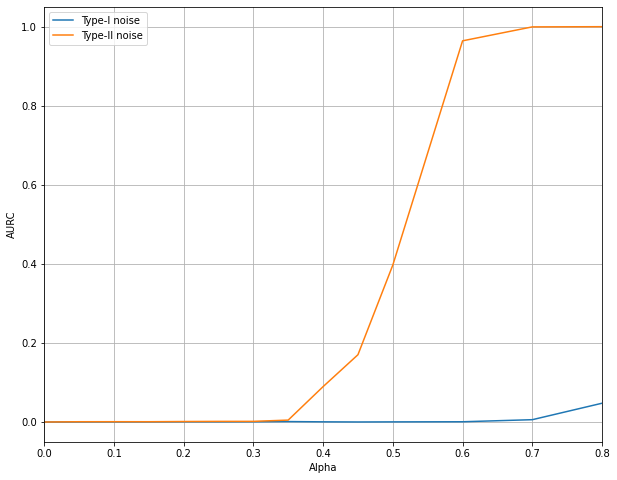

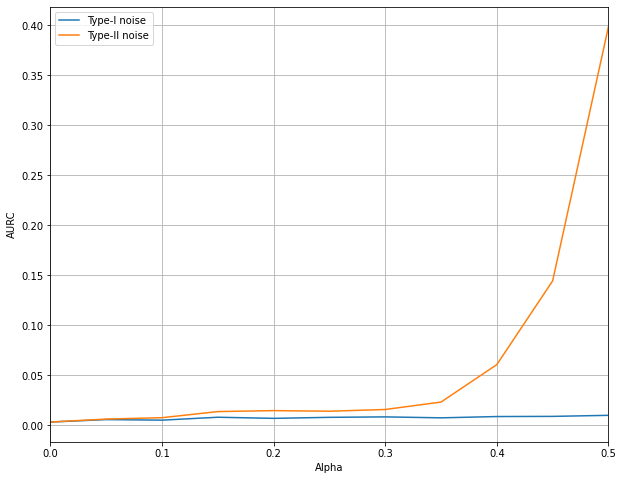

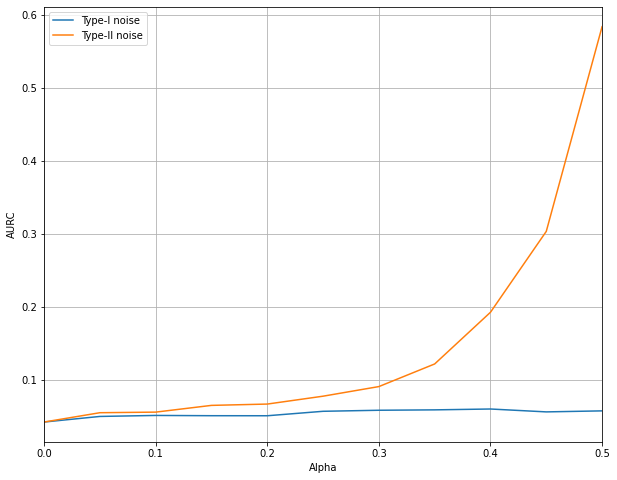

In [ ]:
import matplotlib.pyplot as plt

alpha = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
alpha_all = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5, 0.6, 0.7, 0.8]

mnist_t1 = MNIST_2_AURC
mnist_t2 = MNIST_4_AURC
cifar10_t1 = CIFAR10_2_AURC
cifar10_t2 = CIFAR10_4_AURC
cifar100_t1 = CIFAR100_2_AURC
cifar100_t2 = CIFAR100_4_AURC

plt.plot(alpha_all, mnist_t1, label='Type-I noise')
plt.plot(alpha_all, mnist_t2, label='Type-II noise')
plt.xlim([0.0, 0.8])
# plt.ylim([0, 0.007])
plt.xlabel('Alpha')
plt.ylabel('AURC')
plt.rcParams["figure.figsize"] = (10, 8)
plt.legend(loc='upper left')
plt.grid()
plt.show()

# plt.xlim([0.1, 0.8])
# plt.xlabel('Alpha')
# plt.ylabel('AURC')
# plt.grid()
# plt.show()

plt.plot(alpha, cifar10_t1, label='Type-I noise')
plt.plot(alpha, cifar10_t2, label='Type-II noise')
plt.xlim([0.0, 0.5])
plt.xlabel('Alpha')
#plt.ylim([0.0, 0.3])
plt.ylabel('AURC')
plt.rcParams["figure.figsize"] = (10, 8)
plt.legend(loc='upper left')

plt.grid()
plt.show()

# plt.xlim([0.1, 0.3])
# plt.xlabel('Alpha')
# plt.ylabel('AURC')
# plt.grid()
# plt.show()

plt.plot(alpha, cifar100_t1, label='Type-I noise')
plt.plot(alpha, cifar100_t2, label='Type-II noise')
plt.xlim([0.0, 0.5])
plt.xlabel('Alpha')
plt.ylabel('AURC')
plt.rcParams["figure.figsize"] = (10, 8)
plt.legend(loc='upper left')
plt.grid()
plt.show()
# plt.xlim([0.1, 0.3])
# plt.xlabel('Alpha')
# plt.ylabel('AURC')
# plt.grid()
# plt.show()